---

# Main Processing Pipeline

## Overview

The main processing pipeline handles object detection on input images (and potentially videos in the future). It offers various slicing options to customize the inference process and allows users to specify the computational device for optimal performance.

## Arguments

| **Argument**        | **Description**                                                                                                                                                      | **Default** | **Choices**      |
|---------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------|------------------|
| `model`             | Path to the object detection model.                                                                                                                                    | *Required*  | N/A              |
| `input`             | Path to the input image. *(TODO: accept video)*                                                                                                                       | *Required*  | N/A              |
| `slicing_options`   | Determines the slicing strategy for processing the input.                                                                                                           | `standard`  | `standard`, `slice4`, `slice16` |
| `device`            | Specifies the computation device to use for inference.                                                                                                               | `cuda`      | `cuda`, `mps`, `cpu` |

### Argument Details

- **`model`**
  - **Type:** String
  - **Description:** Path to the object detection model file. Ensure that the model is compatible with the pipeline.

- **`input`**
  - **Type:** String
  - **Description:** Path to the input image file. Future updates will allow video input as well.

- **`slicing_options`**
  - **Type:** String
  - **Description:** 
    - `standard`: Performs standard inference and outputs the results along with bounding boxes.
    - `slice4`: Slices the image into 4 equal parts, processes each slice separately, and then combines the results.
    - `slice16`: Slices the image into 16 equal parts for more granular processing, which can be useful for high-resolution images.

- **`device`**
  - **Type:** String
  - **Description:** Specifies the computational device for running the inference.
    - `cuda`: Utilizes NVIDIA GPUs for accelerated computation. *(Default)*
    - `mps`: Uses Apple’s Metal Performance Shaders for compatible Apple Silicon devices.
    - `cpu`: Runs the inference on the CPU. Use this if GPU support is unavailable or if you prefer CPU processing.

## Future Enhancements

- **Merge bounding box output:** Merge bbox output when slicing, not just hard-coded output image with bounding boxes
- **Tracking:** Use the improved detection results from slicing to improve tracking.
- **Video Input Support:** Extend the `input` argument to accept video files, enabling object detection on video streams.
- **Additional Slicing Options:** Introduce more slicing strategies for different use cases and performance optimizations.
- **Additional models:** Incorporate more models to experiment with the differences between CNN and transformer-based models.

---

In [ ]:
# Import necessary libraries
import os
import cv2
import numpy as np
from ultralytics import RTDETR
import matplotlib.pyplot as plt
from datetime import datetime
import torch

# Ensure matplotlib plots inline in Jupyter 
%matplotlib inline

#Step 0: Set device (cuda/cpu/mps)
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'mps' #replace with 'mps' if using a Apple Silicon, 'cpu' otherwise

# Step 1: Load the model
# Replace 'bestRefinedAABB.pt' with the path to your model
model = RTDETR('bestRefinedAABB.pt')

# Step 2: Define the input image path
# Replace '1aviframe0.jpg' with your input image path
input_path = '1aviframe0.jpg'

# Step 3: Choose the slicing option
# Options: 'standard', 'slice4', 'slice16'
#in testing: slice9 
slicing_option = 'slice16'  # Change this as needed


image 1/1 /Users/palbentsen/Documents/GitHub/Forskningv2/pipeline-v1/output_results/29Nov/run10/slices/slice_01.jpg: 640x640 12 normal_sperms, 178.8ms
Speed: 15.8ms preprocess, 178.8ms inference, 17.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to output_results/29Nov/run10/processed_slices/slice_01
1 label saved to output_results/29Nov/run10/processed_slices/slice_01/labels

image 1/1 /Users/palbentsen/Documents/GitHub/Forskningv2/pipeline-v1/output_results/29Nov/run10/slices/slice_02.jpg: 640x640 16 normal_sperms, 172.7ms
Speed: 2.0ms preprocess, 172.7ms inference, 16.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to output_results/29Nov/run10/processed_slices/slice_02
1 label saved to output_results/29Nov/run10/processed_slices/slice_02/labels

image 1/1 /Users/palbentsen/Documents/GitHub/Forskningv2/pipeline-v1/output_results/29Nov/run10/slices/slice_03.jpg: 640x640 12 normal_sperms, 175.7ms
Speed: 1.8ms preprocess, 175.7ms inference, 18.2ms 

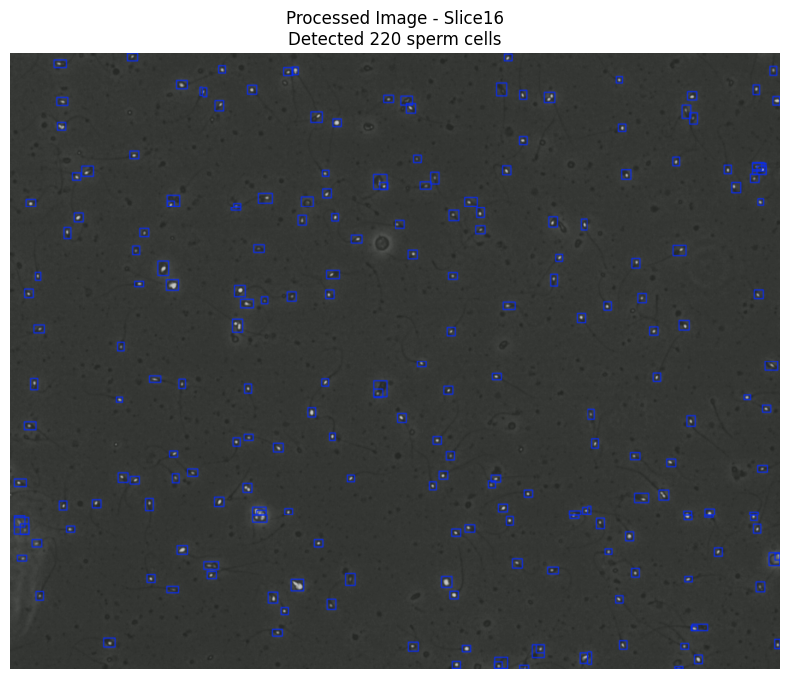

Combined image saved at: output_results/29Nov/run10/processed_slice16.jpg
Total sperm cells detected: 220


In [ ]:
# Get current date and format it as '24Nov'
current_date = datetime.now().strftime('%d%b')

# Create the date folder inside 'output_results'
date_dir = os.path.join('output_results', current_date)
os.makedirs(date_dir, exist_ok=True)

# Determine the next run number
run_num = 1
while True:
    run_dir = os.path.join(date_dir, f'run{run_num}')
    if not os.path.exists(run_dir):
        os.makedirs(run_dir)
        break
    else:
        run_num += 1

# Set the output base directory to the run directory
output_base_dir = run_dir

# Function to display images in Jupyter notebook
def display_image(image, title='Image'):
    # Convert BGR to RGB for correct color display
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 8))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title(title)
    plt.show()

# Function to run inference on an image and return the result image and detection count
def run_inference_on_image(image_path, save_dir):
    # Run inference
    results = model.predict(
        source=image_path,
        save=True,
        save_txt=True,
        save_frames=True,
        show_labels=False,
        show_conf=True,
        save_conf=True,
        project=save_dir,
        name='.',
        exist_ok=True,
        device=device
    )
    # The processed image is saved in the save_dir with the same name
    processed_image_path = os.path.join(save_dir, os.path.basename(image_path))
    processed_image = cv2.imread(processed_image_path)

    # Get the number of detections
    num_detections = 0
    if results and len(results) > 0:
        num_detections = len(results[0].boxes)
    else:
        print(f"Warning: No results returned for image {image_path}")

    return processed_image, num_detections

# Step 5: Process the image based on the slicing option
if slicing_option == 'standard':
    # Run inference on the whole image
    save_dir = os.path.join(output_base_dir, 'standard')
    os.makedirs(save_dir, exist_ok=True)
    processed_image, num_detections = run_inference_on_image(input_path, save_dir)
    if processed_image is not None:
        # Display the processed image with detection count
        title = f'Processed Image - Standard\nDetected {num_detections} sperm cells'
        display_image(processed_image, title=title)
        print(f"Total sperm cells detected: {num_detections}")
    else:
        print("Error: Processed image could not be loaded.")

elif slicing_option in ['slice4', 'slice9', 'slice16']:
    # Determine grid size
    grid_sizes = {'slice4': (2, 2), 'slice9': (3, 3), 'slice16': (4, 4)}
    rows, cols = grid_sizes[slicing_option]

    # Desired output size for each slice (resize to this size before inference)
    output_size = (640, 480)  # Adjust as needed

    # Read the input image
    image = cv2.imread(input_path)
    if image is None:
        print(f"Error: Unable to load image at {input_path}")
    else:
        # Get image dimensions
        height, width = image.shape[:2]
        slice_height = height // rows
        slice_width = width // cols

        # Directories to save slices and processed slices
        slices_dir = os.path.join(output_base_dir, 'slices')
        processed_slices_dir = os.path.join(output_base_dir, 'processed_slices')
        os.makedirs(slices_dir, exist_ok=True)
        os.makedirs(processed_slices_dir, exist_ok=True)

        # Lists to hold processed slices
        processed_slices = []
        total_detections = 0  # Initialize total detection counter
        slice_num = 1  # Start from 1 for consistent naming

        for i in range(rows):
            row_slices = []
            for j in range(cols):
                # Calculate slice coordinates
                y_start = i * slice_height
                y_end = (i + 1) * slice_height if i < rows - 1 else height
                x_start = j * slice_width
                x_end = (j + 1) * slice_width if j < cols - 1 else width

                # Extract slice
                slice_img = image[y_start:y_end, x_start:x_end]
                original_size = (slice_img.shape[1], slice_img.shape[0])  # (width, height)

                # Resize the slice to the desired output size
                resized_slice = cv2.resize(slice_img, output_size, interpolation=cv2.INTER_AREA)

                # Save resized slice image
                slice_filename = f'slice_{slice_num:02d}.jpg'
                slice_path = os.path.join(slices_dir, slice_filename)
                cv2.imwrite(slice_path, resized_slice)

                # Run inference on the resized slice
                slice_save_dir = os.path.join(processed_slices_dir, f'slice_{slice_num:02d}')
                os.makedirs(slice_save_dir, exist_ok=True)
                processed_resized_slice, num_detections = run_inference_on_image(slice_path, slice_save_dir)

                # Update total detections
                total_detections += num_detections

                if processed_resized_slice is not None:
                    # Resize processed slice back to original slice size
                    processed_slice = cv2.resize(
                        processed_resized_slice,
                        original_size,
                        interpolation=cv2.INTER_AREA
                    )
                    row_slices.append(processed_slice)
                else:
                    print(f"Error: Processed slice {slice_num} could not be loaded.")
                    # Use original slice as fallback (resized back to original size)
                    fallback_slice = cv2.resize(resized_slice, original_size, interpolation=cv2.INTER_AREA)
                    row_slices.append(fallback_slice)

                slice_num += 1

            # Concatenate slices horizontally to form a row
            if row_slices:
                row_image = np.hstack(row_slices)
                processed_slices.append(row_image)

        # Concatenate all rows vertically to form the combined image
        if processed_slices:
            combined_image = np.vstack(processed_slices)

            # Save and display the combined image
            combined_image_path = os.path.join(output_base_dir, f'processed_{slicing_option}.jpg')
            cv2.imwrite(combined_image_path, combined_image)
            title = f'Processed Image - {slicing_option.capitalize()}\nDetected {total_detections} sperm cells'
            display_image(combined_image, title=title)
            print(f"Combined image saved at: {combined_image_path}")
            print(f"Total sperm cells detected: {total_detections}")
        else:
            print("Error: No processed slices available to combine.")

else:
    print(f"Error: Invalid slicing option '{slicing_option}'. Please choose 'standard', 'slice4', 'slice9', or 'slice16'.")